In [ ]:
#TAYKO SOFTWARE CATALOGER CASE STUDY

#Tayko is a software catalog firm that sells games and educational software. It started out as a software manufacturer 
#and later added third-party titles to its offerings. It has recently put together a revised collection of items 
# in a new catalog, which it is preparing to roll out in a mailing. In addition to its own software titles, Tayko’s 
#customer list is a key asset. In an attempt to expand its customer base, it has recently joined a consortium of catalog 
#firms that specialize in computer and software products. The consortium affords members the opportunity to mail 
#catalogs to names drawn from a pooled list of customers. Members supply their own customer lists to the pool, and can “withdraw” an
#equivalent number of names each quarter. Members are allowed to do predictive modeling on the records in the pool so 
#they can do a better job of selecting names from the pool.

#THE MAILING EXPERIMENT : Tayko has supplied its customer list of 200,000 names to the pool,
#which totals over 5,000,000 names, so it is now entitled to draw
#200,000 names for a mailing. Tayko would like to select the names
#that have the best chance of performing well, so it conducts a test—it
#draws 20,000 names from the pool and does a test mailing of the new catalog.
#This mailing yielded 1065 purchasers, a response rate of 0.053. To
#optimize the performance of the data mining techniques, it was
#decided to work with a stratified sample that contained equal numbers
#of purchasers and nonpurchasers. For ease of presentation, the dataset
#for this case includes just 1000 purchasers and 1000 nonpurchasers,
#an apparent response rate of 0.5. Therefore, after using the dataset to
#predict who will be a purchaser, we must adjust the purchase rate back
#down by multiplying each case’s “probability of purchase” by 0.053/0.5, or 0.107.

#DATA: There are two outcome variables in this case. Purchase indicates whether or not a prospect responded to the 
#test mailing and purchased something. Spending indicates, for those who made a purchase, how much they spent. 
#The overall procedure in this case will be to develop two models. One will be used to classify records as purchase or 
#no purchase. The second will be used for those cases that are classified as purchase and will predict the amount 
#they will spend.



In [7]:
#Develop a model for classifying a customer as a purchaser or nonpurchaser.
#a. Partition the data randomly into a training set (800 records), validation set (700 records), and test set (500 records).

%matplotlib inline
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, BayesianRidge
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from mord import LogisticIT
import matplotlib.pylab as plt
import seaborn as sns
from dmba import classificationSummary, gainsChart, liftChart
from dmba.metric import AIC_score
from math import log
from dmba import regressionSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score


from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import preprocessing

In [116]:
#Importing data 
case_df=pd.read_csv('Tayko.csv')

In [118]:
#Creating a copy for better understanding and avoiding data loss.
case_df1=case_df

In [119]:
#using this dataset for variable selection
case_df.columns = [c.replace(' ', '_') for c in case_df.columns]
case_df.columns = [c.replace('=', '_') for c in case_df.columns]

#use this dataset for Logistic regression
case_df1.columns = [c.replace(' ', '_') for c in case_df1.columns]
case_df1.columns = [c.replace('=', '_') for c in case_df1.columns]

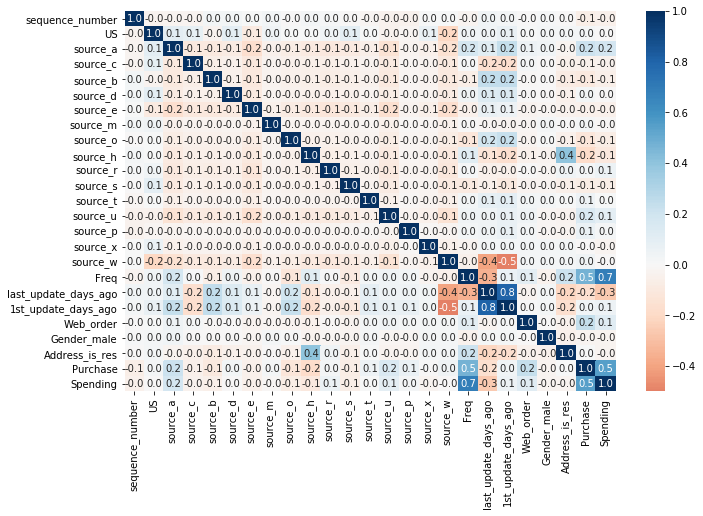

In [120]:
# Running correlation matrix, to deal with multicollinearity
corr = case_df.corr()
fig, ax = plt.subplots()
fig.set_size_inches(11, 7)
sns.heatmap(corr, annot=True, fmt=".1f", cmap="RdBu", center=0, ax=ax)

plt.show()

In [121]:
#Predictor and outcome variables for variable selection
#The above correlations tell us that Spending and Freq, 1st_update_days_ago and last_update_days_ago are highly correlated
# So, that we will remove Spending and last_update_days_ago from our predictor list
# Hence, Sequence_number is just id, So removing it too from the predictor list.
y = case_df['Purchase']
X = case_df.drop(columns=['Purchase','Spending','sequence_number','last_update_days_ago'])


In [122]:
#Splitting the data into training(40% = 800 records), validation(35% = 700 records), and test(25% = 500 records) for variable selection
print('For Variable Selection')
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.6,random_state=1)
test_X, valid_X, test_y, valid_y = train_test_split(valid_X, valid_y, test_size=0.583,random_state=1)
print('Training   : ',train_X.shape) #40% (800 records) of data
print('Validation : ',valid_X.shape) #35% (700 records) of data
print('Test       : ',test_X.shape)  #25% (500 records)of data


For Variable Selection
Training   :  (800, 21)
Validation :  (700, 21)
Test       :  (500, 21)


In [123]:
# Forward Selection
def train_model(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(train_y, [train_y.mean()] * len(train_y), model, df=1)
    return AIC_score(train_y, model.predict(train_X[variables]), model)

best_model, best_variables = forward_selection(train_X.columns, train_model, score_model, verbose=True)


Variables: US, source_a, source_c, source_b, source_d, source_e, source_m, source_o, source_h, source_r, source_s, source_t, source_u, source_p, source_x, source_w, Freq, 1st_update_days_ago, Web_order, Gender_male, Address_is_res
Start: score=1164.66, constant
Step: score=974.35, add Freq
Step: score=926.82, add source_h
Step: score=890.52, add Web_order
Step: score=874.84, add source_a
Step: score=855.18, add source_u
Step: score=850.11, add source_c
Step: score=846.80, add source_r
Step: score=844.72, add 1st_update_days_ago
Step: score=842.27, add source_p
Step: score=841.65, add source_x
Step: score=840.74, add source_d
Step: score=840.65, add Gender_male
Step: score=840.65, add None


In [124]:
#Stepwise regression
best_model, best_variables = stepwise_selection(train_X.columns, train_model, score_model, verbose=True)

print(best_variables)

Variables: US, source_a, source_c, source_b, source_d, source_e, source_m, source_o, source_h, source_r, source_s, source_t, source_u, source_p, source_x, source_w, Freq, 1st_update_days_ago, Web_order, Gender_male, Address_is_res
Start: score=1164.66, constant
Step: score=974.35, add Freq
Step: score=926.82, add source_h
Step: score=890.52, add Web_order
Step: score=874.84, add source_a
Step: score=855.18, add source_u
Step: score=850.11, add source_c
Step: score=846.80, add source_r
Step: score=844.72, add 1st_update_days_ago
Step: score=842.27, add source_p
Step: score=841.65, add source_x
Step: score=840.74, add source_d
Step: score=840.65, add Gender_male
Step: score=840.65, unchanged None
['Freq', 'source_h', 'Web_order', 'source_a', 'source_u', 'source_c', 'source_r', '1st_update_days_ago', 'source_p', 'source_x', 'source_d', 'Gender_male']


In [107]:
# Using the best variables in our logistic regression that we get from running the forward and stepwise selection.
y1 = case_df1['Purchase']
X1 = case_df1[['Freq','source_h','Web_order','source_a','source_u','source_c','source_r','1st_update_days_ago','source_p','source_x','source_d']]
#X1 = case_df2[['Freq','source_h','Web_order','source_a','source_u','source_c','source_r','source_o','source_p','source_w','source_x','source_d']]


In [125]:
#Splitting the data into training(40% = 800 records), validation(35% = 700 records), and test(25% = 500 records) for Logistic regression
print('\nFor Logistic Regression')
train_X1, valid_X1, train_y1, valid_y1 = train_test_split(X1, y1, test_size=0.6,random_state=1)
test_X1, valid_X1, test_y1, valid_y1 = train_test_split(valid_X1, valid_y1, test_size=0.583,random_state=1)
print('Training   : ',train_X1.shape) #40% (800 records) of data
print('Validation : ',valid_X1.shape) #35% (700 records) of data
print('Test       : ',test_X1.shape)  #25% (500 records)of data


For Logistic Regression
Training   :  (800, 11)
Validation :  (700, 11)
Test       :  (500, 11)


In [127]:
#Fit a logistic regression (set penalty=l2 and Cv=3) on Selected variables on validation dataset
logit_reg = LogisticRegressionCV(penalty="l2", solver='liblinear', cv=3)
logit_reg.fit(train_X1, train_y1)

print('intercept ', logit_reg.intercept_[0])
print(pd.DataFrame({'coeff': logit_reg.coef_[0]}, index=X1.columns).transpose())
print()
print('AIC', AIC_score(valid_y1, logit_reg.predict(valid_X1), df = len(train_X1.columns) + 1))

intercept  -2.678410743935177
           Freq  source_h  Web_order  source_a  source_u  source_c  source_r  \
coeff  1.940681 -3.880023   0.929624  1.293511  1.292084 -1.012054  0.840047   

       1st_update_days_ago  source_p  source_x  source_d  
coeff            -0.000137  1.075189  0.985658  0.155195  

AIC 952.6245336456989


In [128]:
#Predict to get probablities on selected variables on validation dataset
logit_red_pred = logit_reg.predict(valid_X1)
logit_red_proba = logit_reg.predict_proba(valid_X1)
logit_result = pd.DataFrame({'actual': valid_y1, 
                             'p(0)': [p[0] for p in logit_red_proba],
                             'p(1)': [p[1] for p in logit_red_proba],
                             'predicted': logit_red_pred })
logit_result.head(5)

,actual,p(0),p(1),predicted
159,1,0.016095,0.983905,1
703,1,0.384371,0.615629,1
320,1,0.124264,0.875736,1
382,0,0.958660,0.041340,0
830,0,0.703696,0.296304,0


In [139]:
# Confusion matrix on selected variables.
classificationSummary(train_y1, logit_reg.predict(train_X1))
classificationSummary(valid_y1, logit_reg.predict(valid_X1))

Confusion Matrix (Accuracy 0.8150)

       Prediction
Actual   0   1
     0 342  69
     1  79 310
Confusion Matrix (Accuracy 0.7800)

       Prediction
Actual   0   1
     0 284  63
     1  91 262


In [130]:
# fit a logistic regression (set penalty=l2 and C=1e42 to avoid regularization) without selecting variables.
logit_reg = LogisticRegressionCV(penalty="l2",solver='liblinear', cv=3)
logit_reg.fit(train_X, train_y)

print('intercept ', logit_reg.intercept_[0])
print(pd.DataFrame({'coeff': logit_reg.coef_[0]}, index=X.columns).transpose())
print()
print('AIC', AIC_score(valid_y, logit_reg.predict(valid_X), df = len(train_X.columns) + 1))

intercept  -2.4928802595723645
             US  source_a  source_c  source_b  source_d  source_e  source_m  \
coeff -0.077603  1.321889 -0.953061 -0.269546  0.215339  0.100633  -0.33483   

       source_o  source_h  source_r  ...  source_t  source_u  source_p  \
coeff -0.291445 -3.562907  0.849765  ...  0.436217  1.274634  1.066337   

       source_x  source_w      Freq  1st_update_days_ago  Web_order  \
coeff  1.158904  0.244942  2.015967            -0.000116    0.88409   

       Gender_male  Address_is_res  
coeff    -0.376864       -0.488991  

[1 rows x 21 columns]

AIC 944.8063035910391


In [131]:
#Predict to get probablities without selecting variables
logit_red_pred = logit_reg.predict(valid_X)
logit_red_proba = logit_reg.predict_proba(valid_X)
logit_result = pd.DataFrame({'actual': valid_y, 
                             'p(0)': [p[0] for p in logit_red_proba],
                             'p(1)': [p[1] for p in logit_red_proba],
                             'predicted': logit_red_pred })
logit_result.head(5)

,actual,p(0),p(1),predicted
159,1,0.015543,0.984457,1
703,1,0.432213,0.567787,1
320,1,0.128725,0.871275,1
382,0,0.950911,0.049089,0
830,0,0.806478,0.193522,0


In [132]:
# Confusion matrix on without selecting variables on validation dataset
classificationSummary(train_y, logit_reg.predict(train_X))
classificationSummary(valid_y, logit_reg.predict(valid_X))

Confusion Matrix (Accuracy 0.8150)

       Prediction
Actual   0   1
     0 338  73
     1  75 314
Confusion Matrix (Accuracy 0.7886)

       Prediction
Actual   0   1
     0 287  60
     1  88 265


In [115]:
# So, for comparison we can see that the confusion matrix of selected variables and unselected set gives us nearly the 
#similar result. It means that we are not losing any data by selecting the variables which is good for our model
# Hence, we are reducing running time and saving our memory by using variable selection technique.

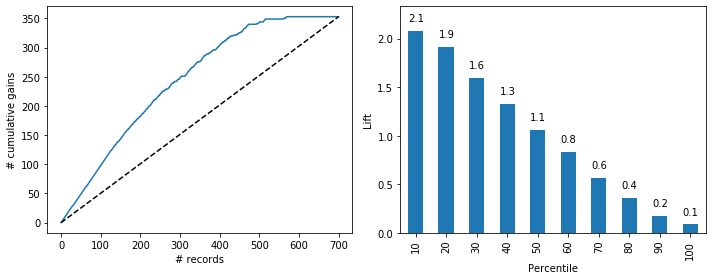

In [141]:
#Lift and gains chart on selected variables on Validation dataset
logit_red_pred = logit_reg.predict(valid_X1)
logit_red_proba = logit_reg.predict_proba(valid_X1)
logit_result = pd.DataFrame({'actual': valid_y1, 
                             'p(0)': [p[0] for p in logit_red_proba],
                             'p(1)': [p[1] for p in logit_red_proba],
                             'predicted': logit_red_pred })

df = logit_result.sort_values(by=['p(1)'], ascending=False)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

gainsChart(df.actual, ax=axes[0])
liftChart(df['p(1)'], title=False, ax=axes[1])
    
plt.tight_layout()
plt.show()

In [134]:
# fit a logistic regression (set penalty=l2 and Cv=3) on Selected variables on test data
logit_reg = LogisticRegressionCV(penalty="l2", solver='liblinear', cv=3)
logit_reg.fit(train_X1, train_y1)

print('intercept ', logit_reg.intercept_[0])
print(pd.DataFrame({'coeff': logit_reg.coef_[0]}, index=X1.columns).transpose())
print()
print('AIC', AIC_score(test_y1, logit_reg.predict(test_X1), df = len(train_X1.columns) + 1))

intercept  -2.678410743935177
           Freq  source_h  Web_order  source_a  source_u  source_c  source_r  \
coeff  1.940681 -3.880023   0.929624  1.293511  1.292084 -1.012054  0.840047   

       1st_update_days_ago  source_p  source_x  source_d  
coeff            -0.000137  1.075189  0.985658  0.155195  

AIC 598.528772518097


In [136]:
#Predict to get probablities on selected variables on test dataset
logit_red_pred = logit_reg.predict(test_X1)
logit_red_proba = logit_reg.predict_proba(test_X1)
logit_result = pd.DataFrame({'actual': test_y1, 
                             'p(0)': [p[0] for p in logit_red_proba],
                             'p(1)': [p[1] for p in logit_red_proba],
                             'predicted': logit_red_pred })
logit_result.head(5)

,actual,p(0),p(1),predicted
1089,0,0.555767,0.444233,0
1874,1,0.115143,0.884857,1
1707,0,0.477254,0.522746,1
790,0,0.941596,0.058404,0
608,0,0.309770,0.690230,1


In [137]:
# Confusion matrix on selected variables on test dataset
classificationSummary(train_y1, logit_reg.predict(train_X1))
classificationSummary(test_y1, logit_reg.predict(test_X1))

Confusion Matrix (Accuracy 0.8150)

       Prediction
Actual   0   1
     0 342  69
     1  79 310
Confusion Matrix (Accuracy 0.8160)

       Prediction
Actual   0   1
     0 197  45
     1  47 211


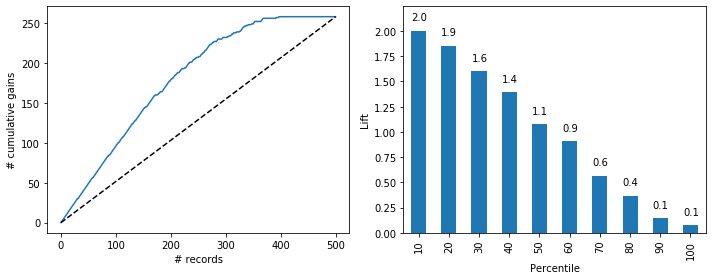

In [143]:
#Lift and gains chart on selected variables on test dataset
logit_red_pred = logit_reg.predict(test_X1)
logit_red_proba = logit_reg.predict_proba(test_X1)
logit_result = pd.DataFrame({'actual': test_y1, 
                             'p(0)': [p[0] for p in logit_red_proba],
                             'p(1)': [p[1] for p in logit_red_proba],
                             'predicted': logit_red_pred })

df = logit_result.sort_values(by=['p(1)'], ascending=False)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

gainsChart(df.actual, ax=axes[0])
liftChart(df['p(1)'], title=False, ax=axes[1])
    
plt.tight_layout()
plt.show()